In [ ]:
import os
def list_folder_tree(path, indent=''):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print(indent + '📁 ' + item)  # Print folder name
            list_folder_tree(item_path, indent + '  ')  # Recursively explore subfolders
#         else:
#             print(indent + '📄 ' + item)  # Print file name

# Specify the root folder path
root_path = '/kaggle/input'

# Call the function to list the folder tree
list_folder_tree(root_path)
# from google.colab import drive
# drive.mount('/content/drive')

📁 mri-segmentation
  📁 mrimages
    📁 mridata


In [16]:
# Import library and set up environment
import pandas as pd
import os as os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = torch.cuda.device_count()
print("Number of GPU workers available:", num_workers)

cuda
Number of GPU workers available: 2


In [3]:
# Path to meta data foler
# The data is part of my course, which is not available in this repository
path_relative_to_drive= '/kaggle/input/mri-segmentation/mrimages/'
# Path to data foler
data_path=path_relative_to_drive+'mridata/'
# Load meta data
meta_train=pd.read_csv(path_relative_to_drive + 'data_train_AML.csv')
meta_valid=pd.read_csv(path_relative_to_drive + 'data_valid_AML.csv')
print('number of train samples', len(meta_train))
print('number of validation samples', len(meta_valid))
print(meta_train.head())

number of train samples 324
number of validation samples 32
   Unnamed: 0 image_name   ga_birth   pma_scan label_name
0           0  1_t2w.jpg  41.142857  41.285714  1_lab.jpg
1           1  2_t2w.jpg  40.142857  40.285714  2_lab.jpg
2           2  3_t2w.jpg  41.142857  41.428571  3_lab.jpg
3           3  4_t2w.jpg  41.285714  41.571429  4_lab.jpg
4           4  5_t2w.jpg  38.571429  38.857143  5_lab.jpg


Size of source image: torch.Size([1, 256, 256])
Size of label image: torch.Size([4, 256, 256])


Text(0.5, 1.0, 'Label 3')

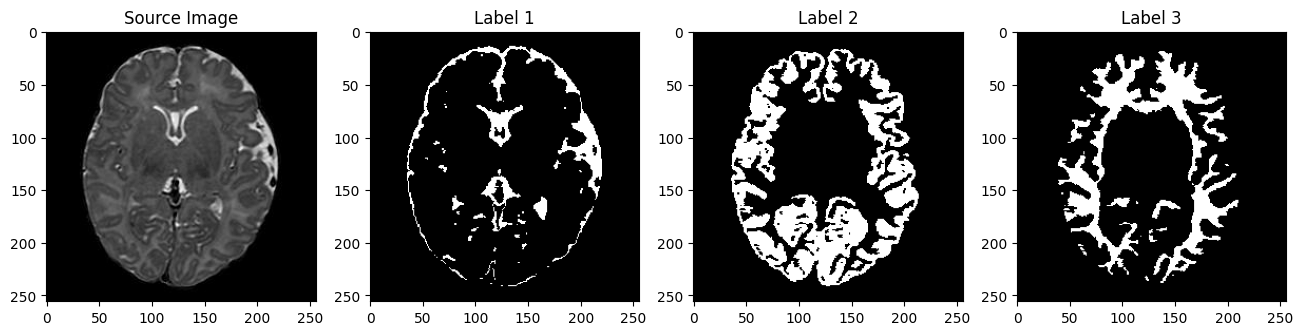

In [4]:
# Create a Dataset class
class my_data_set_for_MRI_npy(Dataset):
    def __init__(self, data_path, meta_data):
        # Store meta data and path
        self.meta_data = meta_data
        self.data_path = data_path
    def __len__(self):
        # Return length of dataset
        return len(self.meta_data)
    def __getitem__(self, index):
        # Concatenate data file names
        image_path=os.path.join(self.data_path,self.meta_data['image_name'][index])
        label_path=os.path.join(self.data_path,self.meta_data['label_name'][index])
        image_path = image_path[0:-3]+'npy'
        label_path = label_path[0:-3]+'npy'
        # Load the data
        image = np.load(image_path)
        image = np.expand_dims(image,axis = 0)
        # Load the label
        label=torch.from_numpy(np.load(label_path)).to(torch.float32)
        # Normalise into range 0-1
        if np.max(image)-np.min(image) !=0:
          image=(image-np.min(image))/(np.max(image)-np.min(image))
        image = torch.from_numpy(image).to(torch.float32)
        return image,label

# Create a train and validation dataset
train = my_data_set_for_MRI_npy(data_path, meta_train)
valid = my_data_set_for_MRI_npy(data_path, meta_valid)
print("Size of source image:", train[0][0].shape)
print("Size of label image:", train[0][1].shape)

# Plot
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(train[0][0][0], cmap = 'gray')
axs[0].set_title('Source Image')
axs[1].imshow(train[0][1][1], cmap = 'gray')
axs[1].set_title('Label 1')
axs[2].imshow(train[0][1][2], cmap = 'gray')
axs[2].set_title('Label 2')
axs[3].imshow(train[0][1][3], cmap = 'gray')
axs[3].set_title('Label 3')


In [18]:
# Create a data loader for batching and shuffling
batch_size = 8
shuffle = True
data_loader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=shuffle, num_workers=2)
data_loader_valid = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=shuffle, num_workers=2)

In [6]:
# Define a block for double convolution
def double_conv(in_channels, out_channels, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding),
        nn.ReLU(inplace=True)
    )
class MyUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Create the layer for downsampling block
        self.dconv_down1 = double_conv(1, 32)
        self.dconv_down2 = double_conv(32, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)

        # Using stride convolution for downsampling
        self.stride_conv1 = nn.Conv2d(32, 32, 3, 2, 1)
        self.stride_conv2 = nn.Conv2d(64, 64, 3, 2, 1)
        self.stride_conv3 = nn.Conv2d(128, 128, 3, 2, 1)
        self.stride_conv4 = nn.Conv2d(256, 256, 3, 2, 1)

        # Batchnorm for regularisation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)

        self.bn4up = nn.BatchNorm2d(256)
        self.bn3up = nn.BatchNorm2d(128)
        self.bn2up = nn.BatchNorm2d(64)
        self.bn1up = nn.BatchNorm2d(32)

        # Upsampling using bi-linear interpolation
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        # Create the layer for upsampling block
        self.dconv_up4 = double_conv(256 + 512, 256)
        self.dconv_up3 = double_conv(128 + 256, 128)
        self.dconv_up2 = double_conv(128 + 64, 64)
        self.dconv_up1 = double_conv(64 + 32, 32)

        # Last convolution layer to match the number of labels
        self.conv_last = nn.Conv2d(32, 4, 1)

    def forward(self, x):
        ##### ENCODER #####
        # First block
        conv1 = self.dconv_down1(x) # 1->32
        conv1 = self.bn1(conv1)
        x = self.stride_conv1(conv1)
        # Second block
        conv2 = self.dconv_down2(x) # 32->64, 1/2
        conv2 = self.bn2(conv2)
        x = self.stride_conv2(conv2)
        # Third block
        conv3 = self.dconv_down3(x) # 64->128, 1/4
        conv3 = self.bn3(conv3)
        x = self.stride_conv3(conv3)
        # Fourth block
        conv4 = self.dconv_down4(x) # 128->256, 1/8
        conv4 = self.bn4(conv4)
        x = self.stride_conv4(conv4)
        # Bottleneck block
        conv5 = self.dconv_down5(x) # 256->512, 1/16
        x = self.bn5(conv5) # x 512, 1/16
        ##### DECODER #####
        # Fourth decode block
        x = self.upsample(x) # 1/8
        x = torch.cat((x, conv4), dim = 1) # 1/8
        x = self.dconv_up4(x)
        x = self.bn4up(x)
        # Third decode block
        x = self.upsample(x) # 1/4
        x = torch.cat((x, conv3), dim = 1) # 1/4
        x = self.dconv_up3(x)
        x = self.bn3up(x)
        # Second decode block
        x = self.upsample(x) # 1/2
        x = torch.cat((x, conv2), dim = 1) # 1/2
        x = self.dconv_up2(x)
        x = self.bn2up(x)
        # First decode block
        x = self.upsample(x) # 1
        x = torch.cat((x, conv1), dim = 1) # 1/2
        x = self.dconv_up1(x)
        x = self.bn1up(x)
        # Softmax to bring value back to 0-1 for multi-classification
        out = F.softmax(self.conv_last(x), dim=1)
        return out


In [19]:
# Loss function: My generalized dice loss
def dice_coeff(prediction, truth):
    epsilon=1e-5
    num_classes = truth.shape[0]
    numerator = 0
    denominator = 0

    weights = torch.unsqueeze(torch.unsqueeze(torch.sum(truth, axis = (2,3)), dim=2), dim=3)
    weights = weights**2
    weights = torch.where(weights!=0, 1/weights,weights)
    numerator = torch.sum(weights*truth*prediction, dim = (1,2,3))
    denominator = torch.sum(weights*(truth+prediction), dim = (1,2,3))
    dice = 2* (numerator / (denominator))
    return dice.mean()
# Declare model
mynet = MyUNet().to(device)
# Declare Adam optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mynet.parameters()), lr=0.001, betas=(0.9,0.999))


In [20]:
# Set the number of training epochs
num_epochs = 10
list_of_loss = []
list_of_dice = []
for epoch in range(num_epochs):
    # Training loop
    mynet.train()
    for i, (image, label) in enumerate(data_loader_train,0):
        # Forward pass
        image = image.to(device)
        label = label.to(device)
        outputs = mynet(image)
        dice = dice_coeff(outputs, label)
        loss = 1-dice
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        list_of_loss.append(loss.item())
        list_of_dice.append(dice.item())
        # Print result mid training
        if i%5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Data [{i*len(label)}/{len(data_loader_train.dataset)}], Loss: {loss.item()}, Dice: {dice.item()}")
    # Testing loop
    mynet.eval()
    epoch_loss = np.empty(0)
    epoch_dice = np.empty(0)
    for i, (image, label) in enumerate(data_loader_valid,0):
        # Forward pass
        image = image.to(device)
        label = label.to(device)
        outputs = mynet(image)
        dice = dice_coeff(outputs, label)
        loss = 1-dice

        epoch_loss=np.append(epoch_loss,loss.item())
        epoch_dice=np.append(epoch_dice,dice.item())
    # Print the result mid training
    print(f"Validation for epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss.mean()}, Dice: {epoch_dice.mean()}")

Epoch [1/10], Data [0/324], Loss: 0.8333562016487122, Dice: 0.16664379835128784
Epoch [1/10], Data [40/324], Loss: 0.5592694282531738, Dice: 0.44073057174682617
Epoch [1/10], Data [80/324], Loss: 0.4304356575012207, Dice: 0.5695643424987793
Epoch [1/10], Data [120/324], Loss: 0.4195898771286011, Dice: 0.5804101228713989
Epoch [1/10], Data [160/324], Loss: 0.3614189624786377, Dice: 0.6385810375213623
Epoch [1/10], Data [200/324], Loss: 0.3335619568824768, Dice: 0.6664380431175232
Epoch [1/10], Data [240/324], Loss: 0.3018866181373596, Dice: 0.6981133818626404
Epoch [1/10], Data [280/324], Loss: 0.26870644092559814, Dice: 0.7312935590744019
Epoch [1/10], Data [160/324], Loss: 0.24164175987243652, Dice: 0.7583582401275635
Validation for epoch [1/10], Loss: 0.7198197245597839, Dice: 0.28018026798963547
Epoch [2/10], Data [0/324], Loss: 0.26240646839141846, Dice: 0.7375935316085815
Epoch [2/10], Data [40/324], Loss: 0.2365279197692871, Dice: 0.7634720802307129
Epoch [2/10], Data [80/324], L

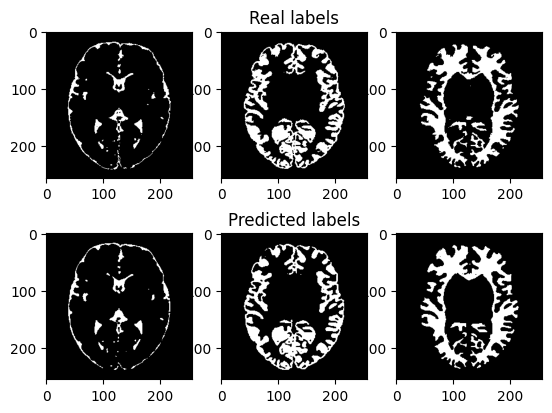

In [21]:
# Plot 1 prediction
image_plot = image.cpu().squeeze()
label_plot = label.cpu()
_, predict = torch.max(outputs, dim=1)
predict = F.one_hot(predict)
predict = predict.permute(0,3,1,2).cpu()

fig, axs = plt.subplots(2, 3)

for i in range(3):
    axs[0,i].imshow(label_plot[0][i+1], cmap = "gray")
    axs[1,i].imshow(predict[0][i+1], cmap = "gray")

axs[0,1].set_title("Real labels")
axs[1,1].set_title("Predicted labels")
plt.show()


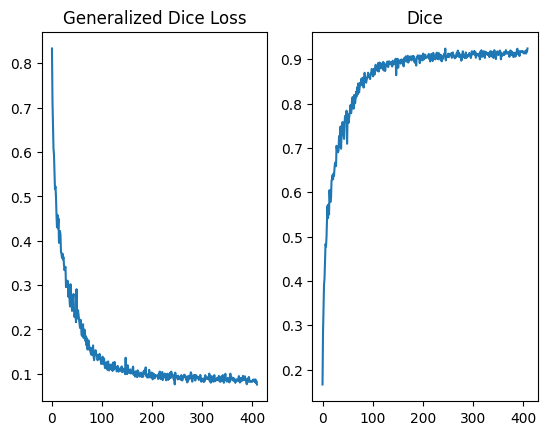

In [22]:
# Plot the loss and dice score
fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(list_of_loss)), list_of_loss, label = "Loss")
axs[1].plot(range(len(list_of_dice)), list_of_dice, label = "Dice score")
axs[0].set_title("Generalized Dice Loss")
axs[1].set_title("Dice")
plt.show()